## Importuojame paketus, paruošiame grafikų stilių

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

## Importuojam duomenis

In [2]:
df = pd.read_csv(
    '../aisdk-2026-02-05.csv',
    engine='pyarrow'
)

In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 15750590 entries, 0 to 15750589
Data columns (total 26 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   # Timestamp                     str    
 1   Type of mobile                  str    
 2   MMSI                            int64  
 3   Latitude                        float64
 4   Longitude                       float64
 5   Navigational status             str    
 6   ROT                             float64
 7   SOG                             float64
 8   COG                             float64
 9   Heading                         float64
 10  IMO                             str    
 11  Callsign                        str    
 12  Name                            str    
 13  Ship type                       str    
 14  Cargo type                      str    
 15  Width                           float64
 16  Length                          float64
 17  Type of position fixing device  str 

## Filtruojam geografinį regioną, navigacinį statusą, `Type of mobile`

In [4]:
df_filtered = df[
    df['Latitude'].between(54, 56) &
    df['Longitude'].between(12, 17) &
    (df['Navigational status'] == 'Under way using engine') &
    (df_filtered['Type of mobile'] == 'Class A')
].copy(deep=True)

del df

## Ištiriam nelogiškas ar nereikalingas reikšmes

In [17]:
df_filtered['Ship type'].value_counts()

Ship type
Cargo              684262
Passenger          263383
Tanker             246091
Pilot              110811
SAR                 92871
Fishing             59486
Other               45911
Dredging            41171
HSC                 40135
Undefined           38660
Tug                 38111
Towing              12116
Spare 1             11088
Law enforcement      8943
Military              153
Name: count, dtype: int64

> `Undefined` nereikia: mums reikia tik laivų, kuriu tipas yra žinomas, kad juos galėtume klasifikuoti, klasterizuoti ir t.t.

In [32]:
df_filtered = df_filtered[ ~(df_filtered['Ship type'] == 'Undefined') ]

In [33]:
numerical = ['Latitude', 'Longitude', 'ROT', 'SOG', 'COG', 'Heading', 'Width', 'Length', 'Draught', 'A', 'B', 'C', 'D']
df_filtered[numerical].max()

Latitude      55.999998
Longitude     16.793983
ROT          697.500000
SOG          102.200000
COG          359.900000
Heading      359.000000
Width         48.000000
Length       293.000000
Draught       14.700000
A            231.000000
B            205.000000
C             27.000000
D             36.000000
dtype: float64

In [34]:
df_filtered[numerical].min()

Latitude      54.004753
Longitude     12.000000
ROT         -231.400000
SOG            0.000000
COG            0.000000
Heading        0.000000
Width          3.000000
Length         8.000000
Draught        0.200000
A              1.000000
B              1.000000
C              1.000000
D              1.000000
dtype: float64

<Axes: xlabel='SOG', ylabel='Ship type'>

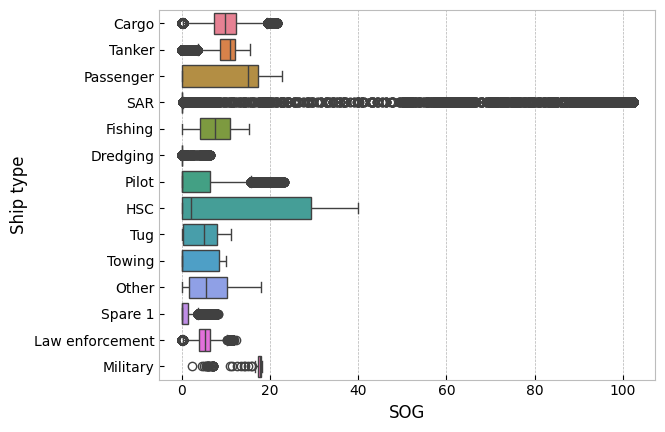

In [37]:
sns.boxplot(y='Ship type', x='SOG', hue='Ship type', data=df_filtered)

> Nelogiškai didelis SOG (100 mazgų ~ 185 kmh) yra paieškos ir gelbėjimo (*angl. Save and rescue, SAR*) laivo, kas nėra nelogiškas greitis

## Transformacijos

In [46]:
df_filtered['COG'] = df_filtered['COG'].apply( lambda x: x if x < 180.0 else 360 - x)
df_filtered['Heading'] = df_filtered['COG'].apply( lambda x: x if x < 180.0 else 360 - x)

In [48]:
relevant_cols = ['# Timestamp', 'MMSI', 'Ship type', 'Latitude', 'Longitude', 'ROT', 'SOG', 'COG', 'Heading']
df_filtered = df_filtered[ relevant_cols ]

In [49]:
df_filtered

,# Timestamp,MMSI,Ship type,Latitude,Longitude,ROT,SOG,COG,Heading
1086,05/02/2026 00:00:06,538006432,Cargo,55.447433,12.665065,0.0,13.3,169.6,169.6
1087,05/02/2026 00:00:06,538006432,Cargo,55.447433,12.665065,0.0,13.3,169.6,169.6
1448,05/02/2026 00:00:08,218058660,Cargo,54.687717,12.579850,0.0,6.5,57.1,57.1
1623,05/02/2026 00:00:09,613961020,Tanker,55.320932,14.409558,1.1,12.0,140.0,140.0
1658,05/02/2026 00:00:09,219002857,Passenger,55.679187,12.593510,NaN,0.0,96.8,96.8
...,...,...,...,...,...,...,...,...,...
15750547,05/02/2026 23:59:58,219002857,Passenger,55.679142,12.593488,NaN,0.0,94.3,94.3
15750556,05/02/2026 23:59:58,215903000,Tanker,55.459912,14.684945,-11.4,7.2,116.5,116.5
15750557,05/02/2026 23:59:58,219927000,Cargo,55.704667,15.719450,-5.4,18.9,101.4,101.4
15750566,05/02/2026 23:59:58,212584000,Cargo,55.736198,15.468068,0.0,10.8,125.4,125.4


In [50]:
df_filtered.to_csv('filtered-df.csv', index=False)